Epoch    0 | loss = 0.003699 | H_curr = 1 | p_tf = 1.000
Epoch  200 | loss = 0.001583 | H_curr = 3 | p_tf = 0.875
Epoch  400 | loss = 0.001657 | H_curr = 5 | p_tf = 0.750
Epoch  600 | loss = 0.000024 | H_curr = 7 | p_tf = 0.625
Epoch  800 | loss = 0.000009 | H_curr = 9 | p_tf = 0.500
Epoch 1000 | loss = 0.000005 | H_curr = 11 | p_tf = 0.375
Epoch 1200 | loss = 0.000003 | H_curr = 12 | p_tf = 0.250
Epoch 1400 | loss = 0.000003 | H_curr = 12 | p_tf = 0.125
Epoch 1600 | loss = 0.000004 | H_curr = 12 | p_tf = 0.000
Epoch 1800 | loss = 0.000001 | H_curr = 12 | p_tf = 0.000


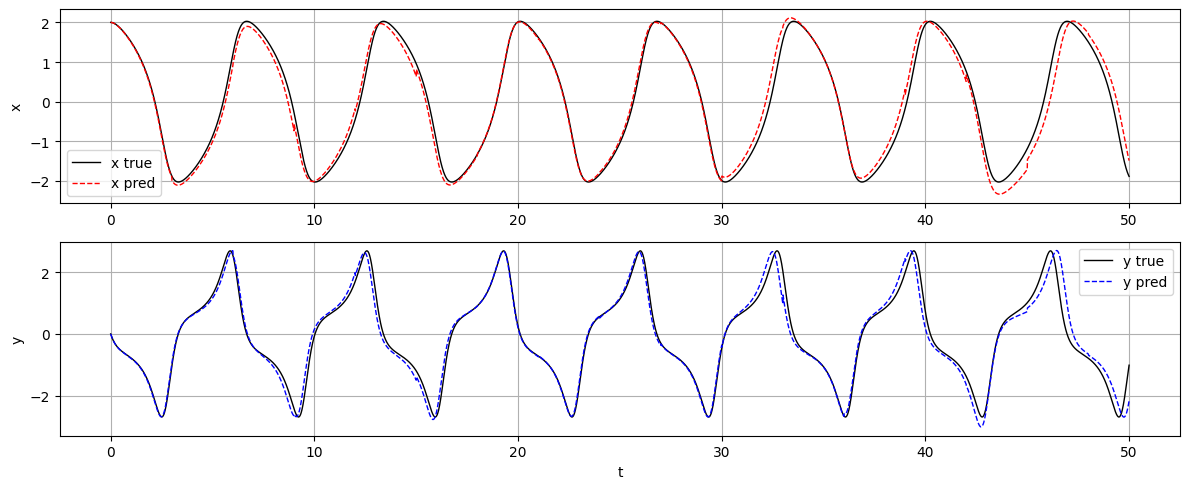

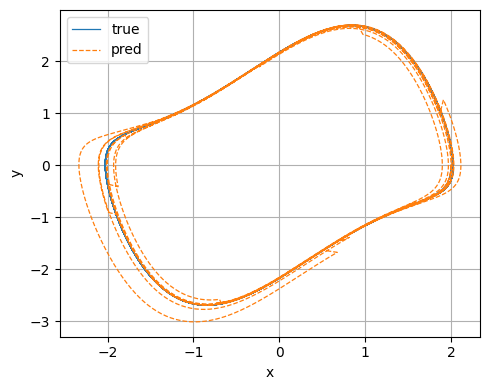

In [18]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ----- Data / sampling -----
T = 50.0            # total duration [s]
DT = 0.01           # integration time step [s]
OBS_DT = 0.05       # observation interval [s]
NOISE_STD = 0.2     # std of Gaussian observation noise
SEED = 0            # random seed (reproducibility)

# ----- Model / optimization -----
HIDDEN = 128        # MLP hidden size
LR = 3e-4           # learning rate (AdamW)
WD = 1e-6           # weight decay (L2 regularization)
BATCH = 1024        # batch size
EPOCHS = 2000       # number of training epochs
H_MAX = 12          # max prediction horizon in curriculum (# of OBS_DT steps)

TF_WARM_RATIO = 0.8

K_SEC = 3.0
GAMMA_CORR = 0.3

torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
torch.set_default_dtype(dtype)

mu_vdp = 1.0
def vdp_true(u, t):
    x, y = u
    return np.array([y, mu_vdp*(1.0 - x*x)*y - x], dtype=np.float64)

def euler_step_true(f, u, t, h):
    return u + h * f(u, t)

N = int(T/DT) + 1
t_full = np.linspace(0.0, T, N).astype(np.float64)
u0 = np.array([2.0, 0.0], dtype=np.float64)

U_true = np.zeros((N, 2), dtype=np.float64)
U_true[0] = u0
for i in range(N-1):
    U_true[i+1] = euler_step_true(vdp_true, U_true[i], t_full[i], DT)

U_noisy = U_true + np.random.normal(0, NOISE_STD, size=U_true.shape).astype(np.float64)

obs_stride = int(round(OBS_DT / DT))
assert obs_stride >= 1 and abs(obs_stride*DT - OBS_DT) < 1e-9
obs_idx = np.arange(0, N, obs_stride)
t_obs = t_full[obs_idx]
Y_obs = U_noisy[obs_idx]
Y_true_obs = U_true[obs_idx]

mu = torch.tensor(U_true.mean(axis=0), device=device)
std = torch.tensor(U_true.std(axis=0) + 1e-8, device=device)

def norm_np(arr): return (arr - mu.cpu().numpy()) / std.cpu().numpy()
def denorm_t(tensor): return tensor * std + mu

Y_obs_std = norm_np(Y_obs)
Y_true_obs_std = norm_np(Y_true_obs)

w_obs_noisy = torch.tensor(Y_obs_std, device=device)          # (M,2) noisy
w_obs_clean = torch.tensor(Y_true_obs_std, device=device)     # (M,2) clean
t_rel = torch.tensor(t_obs - t_obs[0], device=device)
obs_ofs = torch.tensor(obs_idx - obs_idx[0], device=device, dtype=torch.long)
M_obs = len(obs_idx)

n_sub = int(round(OBS_DT / DT))
assert n_sub >= 1

class ODEFunc(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, 2)
        )
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.8)
                nn.init.zeros_(m.bias)
    def forward(self, y, t=None):
        return self.net(y)

# Scheduled Sampling：rollout + teacher forcing
def rollout_with_scheduled_sampling(model, y_start, y_true_seq, n_sub, DT, p_tf):

    B, H1, _ = y_true_seq.shape  # H1=H+1
    y = y_start
    preds = []

    h = torch.as_tensor(DT, device=y.device, dtype=y.dtype).view(1,1)
    for k in range(H1-1):
        for _ in range(n_sub):
            y = y + model(y) * h
        preds.append(y)

        if p_tf > 0.0:
            mask = (torch.rand(B, 1, device=y.device) < p_tf).to(y.dtype)
            y = mask * y_true_seq[:, k+1, :] + (1.0 - mask) * y

    return torch.stack(preds, dim=1)

model = ODEFunc(hidden=HIDDEN).to(device)
opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
loss_fn = nn.SmoothL1Loss(beta=0.5, reduction='mean')

for ep in range(EPOCHS):
    opt.zero_grad()

    H_curr = min(H_MAX, 1 + ep // 100)

    k_batch = torch.randint(0, M_obs-1-H_curr, (BATCH,), device=device)

    y_seq = torch.stack([w_obs_clean[k_batch + i] for i in range(H_curr+1)], dim=1)
    y0_batch = y_seq[:,0,:]  # (B,2)

    progress = ep / (TF_WARM_RATIO * EPOCHS)
    p_tf = float(max(0.0, 1.0 - progress))

    y_preds = rollout_with_scheduled_sampling(model, y0_batch, y_seq, n_sub, DT, p_tf)
    y_tars  = y_seq[:,1:,:]  # (B,H,2)

    loss = loss_fn(y_preds, y_tars)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()

    if ep % 200 == 0:
        print(f"Epoch {ep:4d} | loss = {loss.item():.6f} | H_curr = {H_curr} | p_tf = {p_tf:.3f}")

@torch.no_grad()
def predict_with_periodic_correction(model, y0_std, t_full, obs_idx, w_obs_std,

    n_sub = int(round(OBS_DT / DT))
    K_obs = max(1, int(round(K_sec / OBS_DT)))

    y_list = [y0_std.clone()]
    y = y0_std.clone()
    M = len(obs_idx)
    h = torch.as_tensor(DT, device=y.device, dtype=y.dtype).view(1,1)

    for m in range(1, M):
        for _ in range(n_sub):
            y = y + model(y) * h
            y_list.append(y.clone())

        if (m % K_obs) == 0:
            y_obs = w_obs_std[m:m+1, :]
            y = (1.0 - gamma) * y + gamma * y_obs

    return torch.cat(y_list, dim=0)

with torch.no_grad():
    y0_std = torch.tensor(norm_np(U_true[0:1]), device=device)

    y_pred_std = predict_with_periodic_correction(
        model, y0_std,
        torch.tensor(t_full, device=device),
        obs_idx,
        w_obs_noisy,
        DT=DT, OBS_DT=OBS_DT,
        K_sec=K_SEC, gamma=GAMMA_CORR
    )
    Y_pred = denorm_t(y_pred_std.cpu()).numpy()

Y_true = U_true
t_plot = t_full

plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.plot(t_plot, Y_true[:,0], 'k-', lw=1.0, label='x true')
plt.plot(t_plot, Y_pred[:,0], 'r--', lw=1.0, label='x pred')
plt.ylabel('x'); plt.legend(); plt.grid(True)
plt.subplot(2,1,2)
plt.plot(t_plot, Y_true[:,1], 'k-', lw=1.0, label='y true')
plt.plot(t_plot, Y_pred[:,1], 'b--', lw=1.0, label='y pred')
plt.xlabel('t'); plt.ylabel('y'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
plt.plot(Y_true[:,0], Y_true[:,1], lw=0.9, label='true')
plt.plot(Y_pred[:,0], Y_pred[:,1], '--', lw=0.9, label='pred')
plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()



In [19]:
def print_metrics(Y_true, Y_pred, t, name="FULL"):

    assert Y_true.shape == Y_pred.shape
    eps = 1e-12
    err = Y_pred - Y_true                        # (N, D)

    mse  = np.mean(err**2, axis=0)               # (D,)
    rmse = np.sqrt(mse)
    mae  = np.mean(np.abs(err), axis=0)

    # R^2: 1 - SSE/SST
    sse = np.sum(err**2, axis=0)
    sst = np.sum((Y_true - Y_true.mean(axis=0))**2, axis=0) + eps
    r2  = 1.0 - sse / sst

    std_true = Y_true.std(axis=0) + eps
    rng_true = (Y_true.max(axis=0) - Y_true.min(axis=0)) + eps
    nrmse_std   = rmse / std_true
    nrmse_range = rmse / rng_true

    N, D = Y_true.shape
    print(f"\n=== Metrics ({name}) on N={N} samples ===")
    print(f"{'dim':>4} {'RMSE':>10} {'MAE':>10} {'R2':>8} {'NRMSE/σ':>10} {'NRMSE/range':>14}")
    for i in range(D):
        print(f"x{i:>1} {rmse[i]:10.4f} {mae[i]:10.4f} {r2[i]:8.4f} {nrmse_std[i]:10.4f} {nrmse_range[i]:14.4f}")
    print(f"{'avg':>4} {rmse.mean():10.4f} {mae.mean():10.4f} {r2.mean():8.4f} "
          f"{nrmse_std.mean():10.4f} {nrmse_range.mean():14.4f}")

Yt_eval = Y_true[:len(t_plot)]
Yp_eval = Y_pred[:len(t_plot)]
print_metrics(Yt_eval, Yp_eval, t_plot, name="full trajectory")

for tend in [3, 5, 10, T]:
    mask = (t_plot <= tend)
    print_metrics(Yt_eval[mask], Yp_eval[mask], t_plot[mask], name=f"0–{tend}s")


=== Metrics (full trajectory) on N=5001 samples ===
 dim       RMSE        MAE       R2    NRMSE/σ    NRMSE/range
x0     0.2237     0.1602   0.9759     0.1553         0.0552
x1     0.2638     0.1670   0.9664     0.1832         0.0490
 avg     0.2438     0.1636   0.9712     0.1693         0.0521

=== Metrics (0–3s) on N=301 samples ===
 dim       RMSE        MAE       R2    NRMSE/σ    NRMSE/range
x0     0.0324     0.0263   0.9993     0.0272         0.0084
x1     0.0436     0.0290   0.9968     0.0563         0.0162
 avg     0.0380     0.0277   0.9980     0.0418         0.0123

=== Metrics (0–5s) on N=501 samples ===
 dim       RMSE        MAE       R2    NRMSE/σ    NRMSE/range
x0     0.0645     0.0529   0.9981     0.0436         0.0160
x1     0.0475     0.0346   0.9982     0.0425         0.0120
 avg     0.0560     0.0437   0.9981     0.0431         0.0140

=== Metrics (0–10s) on N=1001 samples ===
 dim       RMSE        MAE       R2    NRMSE/σ    NRMSE/range
x0     0.1634     0.1279   0

Epoch    0 | loss=0.115184 | H=1 | p_tf=1.000
Epoch  200 | loss=0.067193 | H=3 | p_tf=0.875
Epoch  400 | loss=0.042710 | H=5 | p_tf=0.750
Epoch  600 | loss=0.022500 | H=7 | p_tf=0.625
Epoch  800 | loss=0.009954 | H=9 | p_tf=0.500
Epoch 1000 | loss=0.004338 | H=11 | p_tf=0.375
Epoch 1200 | loss=0.004023 | H=13 | p_tf=0.250
Epoch 1400 | loss=0.006923 | H=15 | p_tf=0.125
Epoch 1600 | loss=0.010405 | H=16 | p_tf=0.000
Epoch 1800 | loss=0.009448 | H=16 | p_tf=0.000


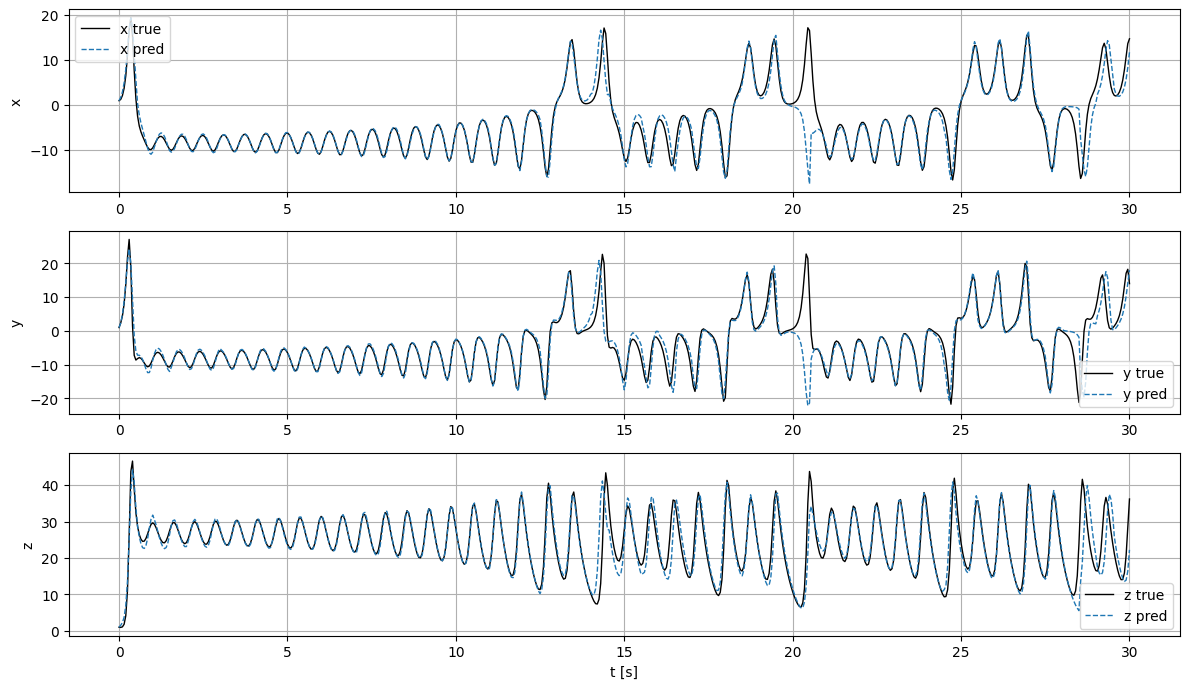

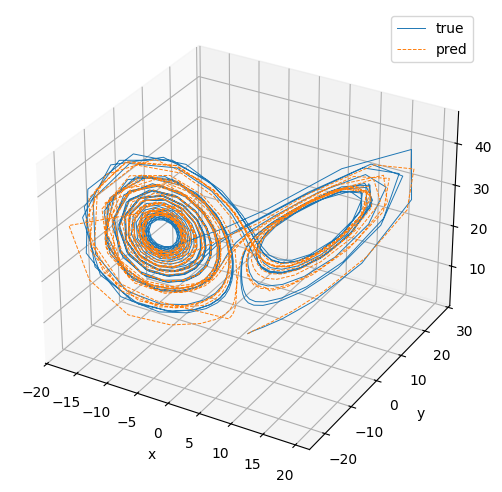

In [14]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

T = 30.0
DT = 0.05
OBS_DT = 0.05
NOISE_STD = 0.5
SEED = 0

HIDDEN = 256
LR = 3e-4
WD = 1e-6
BATCH = 1024
EPOCHS = 2000
H_MAX = 16

# A/B
TF_WARM_RATIO = 0.8
K_SEC = 0.5
GAMMA_CORR = 0.35

torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
torch.set_default_dtype(dtype)

def f_np(u, s, b, r):
    x, y, z = u
    return np.array([s*(y-x), x*(r - z) - y, x*y - b*z], dtype=np.float64)

def rk4_np(f, u0, t, dt, *args):
    U = np.zeros((len(t), 3), dtype=np.float64)
    U[0] = u0
    u = u0.copy()
    for i in range(len(t)-1):
        k1 = f(u, *args)
        k2 = f(u + 0.5*dt*k1, *args)
        k3 = f(u + 0.5*dt*k2, *args)
        k4 = f(u + dt*k3, *args)
        u = u + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        U[i+1] = u
    return U

sigma, beta, rho = 10.0, 8.0/3.0, 28.0
N = int(T/DT) + 1
t_full = np.linspace(0.0, T, N).astype(np.float64)
u0 = np.array([1.0, 1.0, 1.0], dtype=np.float64)

U_true = rk4_np(f_np, u0, t_full, DT, sigma, beta, rho)
U_noisy = U_true + np.random.normal(0, NOISE_STD, size=U_true.shape).astype(np.float64)

obs_stride = int(round(OBS_DT/DT))
assert obs_stride >= 1 and abs(obs_stride*DT - OBS_DT) < 1e-9
obs_idx = np.arange(0, N, obs_stride)
t_obs = t_full[obs_idx]
Y_obs = U_noisy[obs_idx]
Y_true_obs = U_true[obs_idx]

mu = torch.tensor(U_true.mean(axis=0), device=device)
std = torch.tensor(U_true.std(axis=0) + 1e-8, device=device)
def norm_np(arr): return (arr - mu.cpu().numpy()) / std.cpu().numpy()
def denorm_t(tensor): return tensor * std + mu

Y_obs_std = norm_np(Y_obs)
Y_true_obs_std = norm_np(Y_true_obs)

w_obs_noisy = torch.tensor(Y_obs_std, device=device)      # (M,3)
w_obs_clean = torch.tensor(Y_true_obs_std, device=device) # (M,3)
M_obs = len(obs_idx)
n_sub = int(round(OBS_DT/DT))

class ODEFunc(nn.Module):
    def __init__(self, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, 3)
        )
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.8)
                nn.init.zeros_(m.bias)
    def forward(self, y):
        return self.net(y)

@torch.no_grad()
def rk4_step_model(model, y, h):
    # y: (B,3) or (1,3), h: scalar tensor
    k1 = model(y)
    k2 = model(y + 0.5*h*k1)
    k3 = model(y + 0.5*h*k2)
    k4 = model(y + h*k3)
    return y + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def rk4_step_model_train(model, y, h):
    k1 = model(y)
    k2 = model(y + 0.5*h*k1)
    k3 = model(y + 0.5*h*k2)
    k4 = model(y + h*k3)
    return y + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def rollout_with_scheduled_sampling(model, y_start, y_true_seq, n_sub, DT, p_tf):

    B, H1, _ = y_true_seq.shape
    y = y_start
    preds = []
    h = torch.as_tensor(DT, device=y.device, dtype=y.dtype)

    for k in range(H1-1):
        for _ in range(n_sub):
            y = rk4_step_model_train(model, y, h)
        preds.append(y)

        if p_tf > 0.0:
            mask = (torch.rand(B, 1, device=y.device) < p_tf).to(y.dtype)
            y = mask * y_true_seq[:, k+1, :] + (1.0 - mask) * y

    return torch.stack(preds, dim=1)  # (B,H,3)

model = ODEFunc(hidden=HIDDEN).to(device)
opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
loss_fn = nn.SmoothL1Loss(beta=0.5, reduction='mean')

for ep in range(EPOCHS):
    opt.zero_grad()

    H_curr = min(H_MAX, 1 + ep // 100)

    k_batch = torch.randint(0, M_obs-1-H_curr, (BATCH,), device=device)
    y_seq = torch.stack([w_obs_clean[k_batch + i] for i in range(H_curr+1)], dim=1)  # (B,H+1,3)
    y0_batch = y_seq[:,0,:]

    progress = ep / (TF_WARM_RATIO * EPOCHS)
    p_tf = float(max(0.0, 1.0 - progress))

    y_preds = rollout_with_scheduled_sampling(model, y0_batch, y_seq, n_sub, DT, p_tf)  # (B,H,3)
    y_tars  = y_seq[:,1:,:]

    loss = loss_fn(y_preds, y_tars)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()

    if ep % 200 == 0:
        print(f"Epoch {ep:4d} | loss={loss.item():.6f} | H={H_curr} | p_tf={p_tf:.3f}")

@torch.no_grad()
def predict_with_periodic_correction(model, y0_std, obs_idx, w_obs_std,
                                     DT, OBS_DT, K_sec=0.5, gamma=0.35):
    n_sub = int(round(OBS_DT/DT))
    K_obs = max(1, int(round(K_sec/OBS_DT)))
    h = torch.as_tensor(DT, device=y0_std.device, dtype=y0_std.dtype)

    N = int((obs_idx[-1] - obs_idx[0]) + 1)

    y_list = [y0_std.clone()]
    y = y0_std.clone()

    M = len(obs_idx)
    for m in range(1, M):
        for _ in range(n_sub):
            y = rk4_step_model(model, y, h)
            y_list.append(y.clone())
        if (m % K_obs) == 0:
            y_obs = w_obs_std[m:m+1, :]
            y = (1.0 - gamma) * y + gamma * y_obs

    return torch.cat(y_list, dim=0)  # (N,3)

with torch.no_grad():
    y0_std = torch.tensor(norm_np(U_true[0:1]), device=device)

    y_pred_std = predict_with_periodic_correction(
        model, y0_std,
        obs_idx,
        torch.tensor(Y_obs_std, device=device),
        DT=DT, OBS_DT=OBS_DT,
        K_sec=K_SEC, gamma=GAMMA_CORR
    )
    Y_pred = denorm_t(y_pred_std.cpu()).numpy()

Y_true = U_true
t_plot = t_full[:Y_pred.shape[0]]

plt.figure(figsize=(12,7))
labels = ['x','y','z']
colors = ['r','g','b']
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(t_plot, Y_true[:len(t_plot), i], 'k-', lw=1.0, label=f'{labels[i]} true')
    plt.plot(t_plot, Y_pred[:len(t_plot), i], '--', lw=1.0, label=f'{labels[i]} pred')
    plt.ylabel(labels[i]); plt.legend(); plt.grid(True)
plt.xlabel('t [s]')
plt.tight_layout(); plt.show()

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot(Y_true[:,0], Y_true[:,1], Y_true[:,2], lw=0.7, label='true')
ax.plot(Y_pred[:,0], Y_pred[:,1], Y_pred[:,2], '--', lw=0.7, label='pred')
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
ax.legend(); plt.tight_layout(); plt.show()


In [16]:
def print_metrics(Y_true, Y_pred, t, name="FULL"):

    assert Y_true.shape == Y_pred.shape
    eps = 1e-12
    err = Y_pred - Y_true                        # (N, D)

    mse  = np.mean(err**2, axis=0)               # (D,)
    rmse = np.sqrt(mse)
    mae  = np.mean(np.abs(err), axis=0)

    # R^2: 1 - SSE/SST
    sse = np.sum(err**2, axis=0)
    sst = np.sum((Y_true - Y_true.mean(axis=0))**2, axis=0) + eps
    r2  = 1.0 - sse / sst

    std_true = Y_true.std(axis=0) + eps
    rng_true = (Y_true.max(axis=0) - Y_true.min(axis=0)) + eps
    nrmse_std   = rmse / std_true
    nrmse_range = rmse / rng_true

    N, D = Y_true.shape
    print(f"\n=== Metrics ({name}) on N={N} samples ===")
    print(f"{'dim':>4} {'RMSE':>10} {'MAE':>10} {'R2':>8} {'NRMSE/σ':>10} {'NRMSE/range':>14}")
    for i in range(D):
        print(f"x{i:>1} {rmse[i]:10.4f} {mae[i]:10.4f} {r2[i]:8.4f} {nrmse_std[i]:10.4f} {nrmse_range[i]:14.4f}")
    print(f"{'avg':>4} {rmse.mean():10.4f} {mae.mean():10.4f} {r2.mean():8.4f} "
          f"{nrmse_std.mean():10.4f} {nrmse_range.mean():14.4f}")

Yt_eval = Y_true[:len(t_plot)]
Yp_eval = Y_pred[:len(t_plot)]
print_metrics(Yt_eval, Yp_eval, t_plot, name="full trajectory")

for tend in [3, 5, 10, T]:
    mask = (t_plot <= tend)
    print_metrics(Yt_eval[mask], Yp_eval[mask], t_plot[mask], name=f"0–{tend}s")


=== Metrics (full trajectory) on N=601 samples ===
 dim       RMSE        MAE       R2    NRMSE/σ    NRMSE/range
x0     3.0810     1.2286   0.8190     0.4254         0.0853
x1     4.2384     1.6725   0.7354     0.5143         0.0867
x2     3.4600     1.6811   0.7999     0.4474         0.0758
 avg     3.5931     1.5274   0.7848     0.4624         0.0826

=== Metrics (0–3s) on N=61 samples ===
 dim       RMSE        MAE       R2    NRMSE/σ    NRMSE/range
x0     1.0706     0.6771   0.9759     0.1552         0.0360
x1     1.5286     0.9064   0.9622     0.1944         0.0401
x2     1.3216     0.9724   0.9755     0.1566         0.0289
 avg     1.3070     0.8520   0.9712     0.1687         0.0350

=== Metrics (0–5s) on N=101 samples ===
 dim       RMSE        MAE       R2    NRMSE/σ    NRMSE/range
x0     0.8341     0.4421   0.9780     0.1484         0.0278
x1     1.1972     0.6289   0.9648     0.1877         0.0309
x2     1.0405     0.6759   0.9764     0.1535         0.0228
 avg     1.0239  

Epoch    0 | loss = 0.003821 | H_curr = 1 | p_tf = 1.000
Epoch  200 | loss = 0.001297 | H_curr = 3 | p_tf = 0.875
Epoch  400 | loss = 0.000692 | H_curr = 5 | p_tf = 0.750
Epoch  600 | loss = 0.000114 | H_curr = 7 | p_tf = 0.625
Epoch  800 | loss = 0.000038 | H_curr = 9 | p_tf = 0.500
Epoch 1000 | loss = 0.000022 | H_curr = 11 | p_tf = 0.375
Epoch 1200 | loss = 0.000017 | H_curr = 12 | p_tf = 0.250
Epoch 1400 | loss = 0.000016 | H_curr = 12 | p_tf = 0.125
Epoch 1600 | loss = 0.000020 | H_curr = 12 | p_tf = 0.000
Epoch 1800 | loss = 0.000010 | H_curr = 12 | p_tf = 0.000


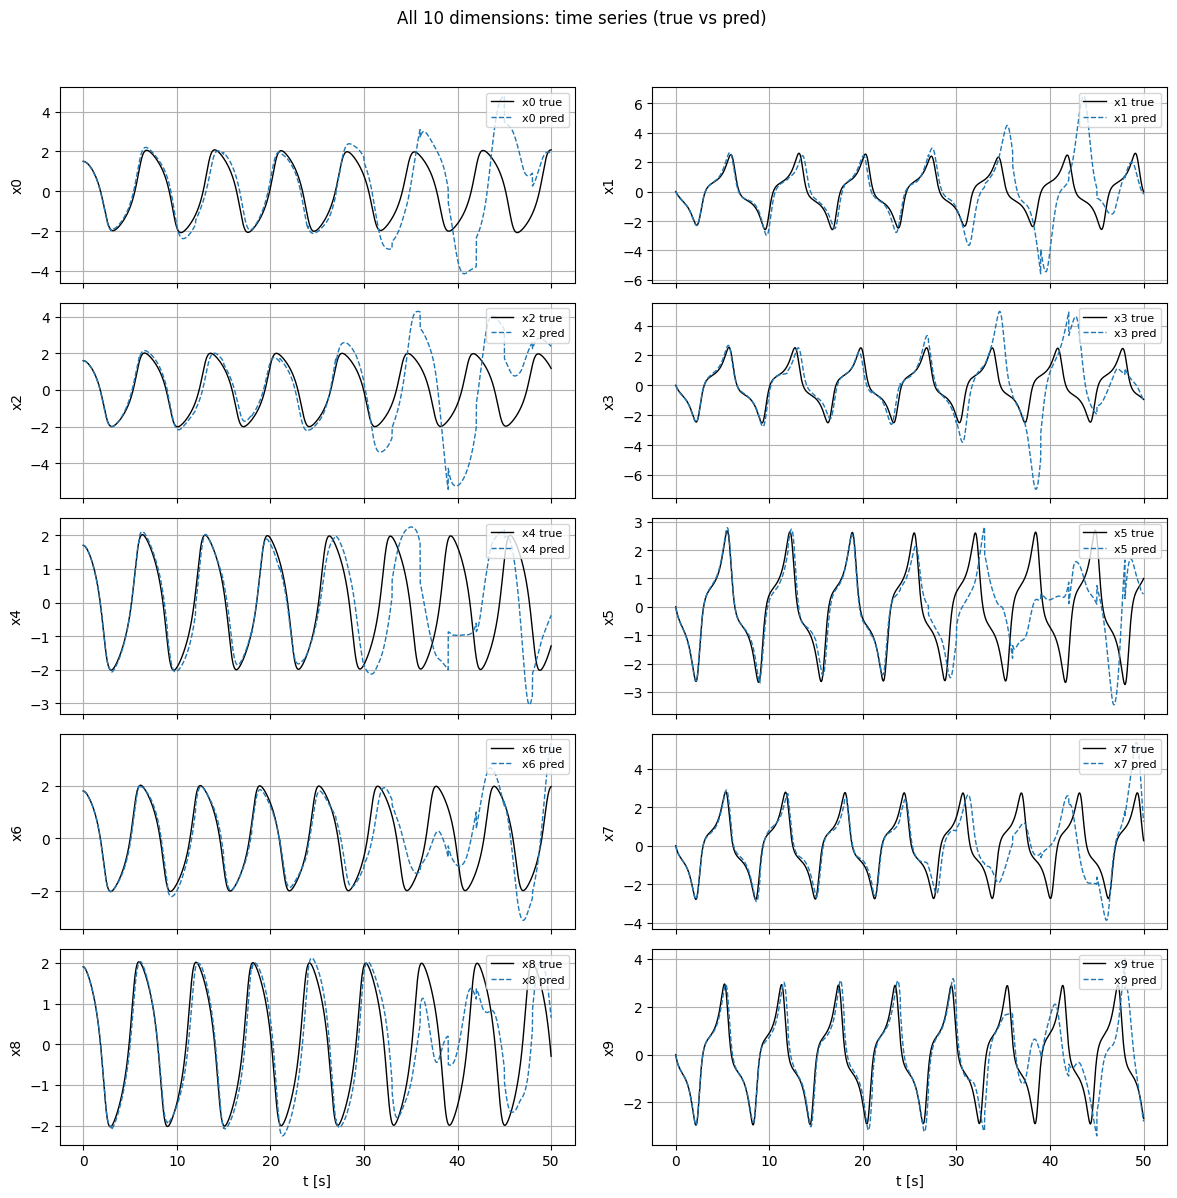

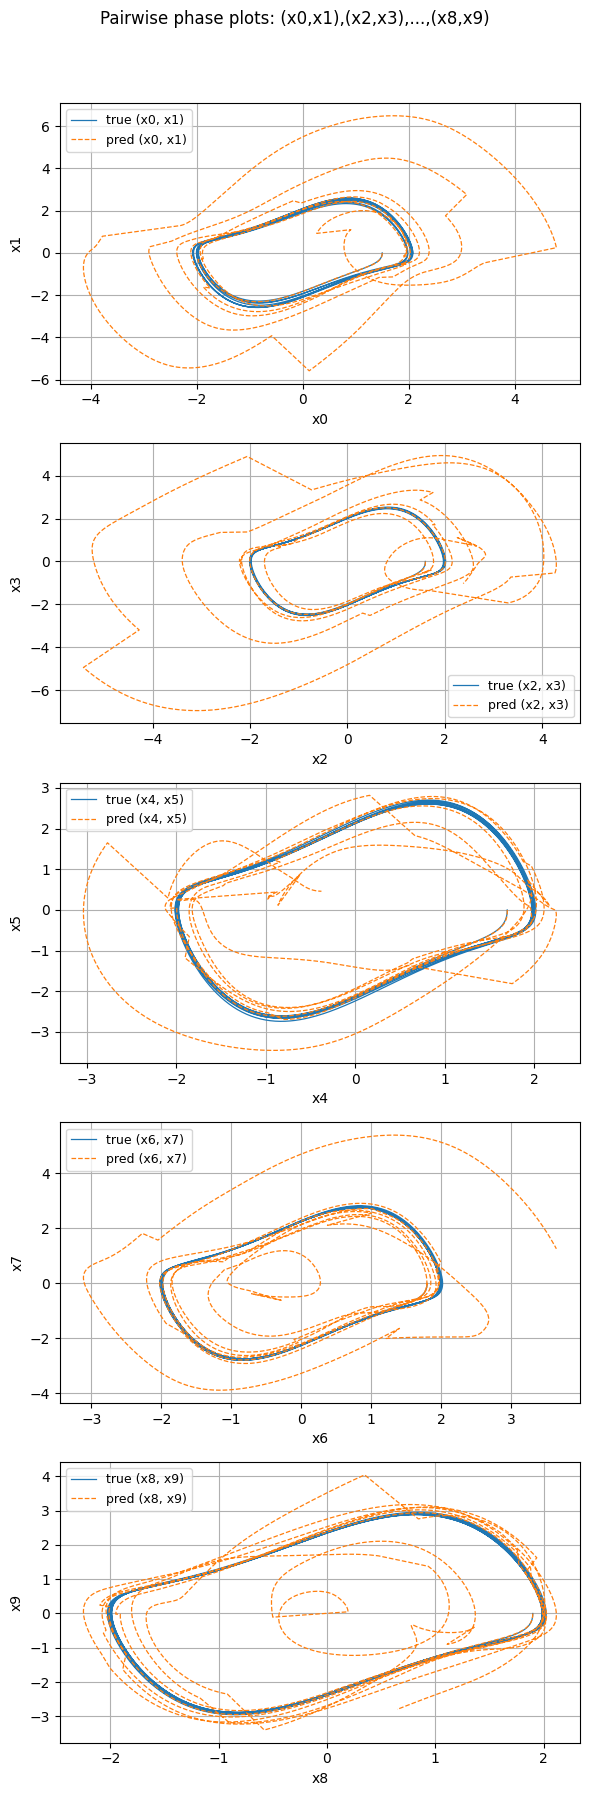

In [20]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

T = 50.0            # total duration [s]
DT = 0.01           # integration time step [s]
OBS_DT = 0.05       # observation interval [s]
NOISE_STD = 0.2     # std of Gaussian observation noise
SEED = 0            # random seed (reproducibility)

HIDDEN = 256        # MLP hidden size
LR = 3e-4           # learning rate (AdamW)
WD = 1e-6           # weight decay (L2 regularization)
BATCH = 1024        # batch size
EPOCHS = 2000       # number of training epochs
H_MAX = 12          # max prediction horizon in curriculum (# of OBS_DT steps)

TF_WARM_RATIO = 0.8
K_SEC = 3.0
GAMMA_CORR = 0.3

DIM = 10
NUM_PAIRS = DIM // 2

torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
torch.set_default_dtype(dtype)

# dq = p
# dp = mu_k*(1 - q^2)*p - omega_k^2 * q + ε*(q_{k-1} - q_k)
mus    = np.linspace(0.9, 1.1, NUM_PAIRS)
omegas = np.linspace(0.9, 1.1, NUM_PAIRS)
eps = 0.05

def f10_true(u, t):
    du = np.zeros_like(u, dtype=np.float64)
    for k in range(NUM_PAIRS):
        q = u[2*k]
        p = u[2*k+1]
        q_prev = u[2*((k-1) % NUM_PAIRS)]
        mu_k = mus[k]
        om2  = omegas[k]**2
        dq = p
        dp = mu_k*(1.0 - q*q)*p - om2*q + eps*(q_prev - q)
        du[2*k]   = dq
        du[2*k+1] = dp
    return du

def euler_step_true(f, u, t, h):
    return u + h * f(u, t)

N = int(T/DT) + 1
t_full = np.linspace(0.0, T, N).astype(np.float64)

u0 = np.zeros(DIM, dtype=np.float64)
for k in range(NUM_PAIRS):
    u0[2*k]   = 1.5 + 0.1*k
    u0[2*k+1] = 0.0

U_true = np.zeros((N, DIM), dtype=np.float64)
U_true[0] = u0
for i in range(N-1):
    U_true[i+1] = euler_step_true(f10_true, U_true[i], t_full[i], DT)

U_noisy = U_true + np.random.normal(0, NOISE_STD, size=U_true.shape).astype(np.float64)

obs_stride = int(round(OBS_DT / DT))
assert obs_stride >= 1 and abs(obs_stride*DT - OBS_DT) < 1e-9
obs_idx = np.arange(0, N, obs_stride)
t_obs = t_full[obs_idx]
Y_obs = U_noisy[obs_idx]
Y_true_obs = U_true[obs_idx]

mu = torch.tensor(U_true.mean(axis=0), device=device)
std = torch.tensor(U_true.std(axis=0) + 1e-8, device=device)

def norm_np(arr): return (arr - mu.cpu().numpy()) / std.cpu().numpy()
def denorm_t(tensor): return tensor * std + mu

Y_obs_std = norm_np(Y_obs)               # noisy
Y_true_obs_std = norm_np(Y_true_obs)

w_obs_noisy = torch.tensor(Y_obs_std, device=device)          # (M,D) noisy
w_obs_clean = torch.tensor(Y_true_obs_std, device=device)     # (M,D) clean
M_obs = len(obs_idx)

n_sub = int(round(OBS_DT / DT))
assert n_sub >= 1

class ODEFunc(nn.Module):
    def __init__(self, dim=DIM, hidden=HIDDEN):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, dim)
        )
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.8)
                nn.init.zeros_(m.bias)
    def forward(self, y, t=None):
        return self.net(y)

# Scheduled Sampling rollout
def rollout_with_scheduled_sampling(model, y_start, y_true_seq, n_sub, DT, p_tf):

    B, H1, D = y_true_seq.shape  # H1=H+1
    y = y_start
    preds = []

    h = torch.as_tensor(DT, device=y.device, dtype=y.dtype).view(1,1)
    for k in range(H1-1):
        for _ in range(n_sub):
            y = y + model(y) * h
        preds.append(y)

        if p_tf > 0.0:
            mask = (torch.rand(B, 1, device=y.device) < p_tf).to(y.dtype)
            y = mask * y_true_seq[:, k+1, :] + (1.0 - mask) * y

    return torch.stack(preds, dim=1)  # (B,H,D)

model = ODEFunc(dim=DIM, hidden=HIDDEN).to(device)
opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
loss_fn = nn.SmoothL1Loss(beta=0.5, reduction='mean')

for ep in range(EPOCHS):
    opt.zero_grad()

    H_curr = min(H_MAX, 1 + ep // 100)

    k_batch = torch.randint(0, M_obs-1-H_curr, (BATCH,), device=device)

    y_seq = torch.stack([w_obs_clean[k_batch + i] for i in range(H_curr+1)], dim=1)  # (B,H+1,D)
    y0_batch = y_seq[:,0,:]  # (B,D)

    # scheduled sampling  TF_WARM_RATIO*EPOCHS 1 -> 0
    progress = ep / (TF_WARM_RATIO * EPOCHS)
    p_tf = float(max(0.0, 1.0 - progress))

    # rollout
    y_preds = rollout_with_scheduled_sampling(model, y0_batch, y_seq, n_sub, DT, p_tf)  # (B,H,D)
    y_tars  = y_seq[:,1:,:]  # (B,H,D)

    loss = loss_fn(y_preds, y_tars)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()

    if ep % 200 == 0:
        print(f"Epoch {ep:4d} | loss = {loss.item():.6f} | H_curr = {H_curr} | p_tf = {p_tf:.3f}")

@torch.no_grad()
def predict_with_periodic_correction(model, y0_std, obs_idx, w_obs_std,
                                     DT, OBS_DT, K_sec=3.0, gamma=0.3):
    n_sub = int(round(OBS_DT / DT))
    K_obs = max(1, int(round(K_sec / OBS_DT)))

    y_list = [y0_std.clone()]
    y = y0_std.clone()
    M = len(obs_idx)
    h = torch.as_tensor(DT, device=y.device, dtype=y.dtype).view(1,1)

    for m in range(1, M):
        for _ in range(n_sub):
            y = y + model(y) * h
            y_list.append(y.clone())

        if (m % K_obs) == 0:
            y_obs = w_obs_std[m:m+1, :]
            y = (1.0 - gamma) * y + gamma * y_obs

    return torch.cat(y_list, dim=0)  # (N,D)

with torch.no_grad():
    y0_std = torch.tensor(norm_np(U_true[0:1]), device=device)
    y_pred_std = predict_with_periodic_correction(
        model, y0_std,
        obs_idx,
        w_obs_noisy,
        DT=DT, OBS_DT=OBS_DT,
        K_sec=K_SEC, gamma=GAMMA_CORR
    )
    Y_pred = denorm_t(y_pred_std.cpu()).numpy()

Y_true = U_true
t_plot = t_full

fig, axs = plt.subplots(5, 2, figsize=(12, 12), sharex=True)
axs = axs.ravel()
for i in range(DIM):
    axs[i].plot(t_plot, Y_true[:, i], 'k-', lw=1.0, label=f'x{i} true')
    axs[i].plot(t_plot, Y_pred[:, i], '--', lw=1.0, label=f'x{i} pred')
    axs[i].set_ylabel(f'x{i}')
    axs[i].grid(True)
    axs[i].legend(fontsize=8, loc='upper right')
axs[-2].set_xlabel('t [s]')
axs[-1].set_xlabel('t [s]')
fig.suptitle('All 10 dimensions: time series (true vs pred)', y=0.995)
plt.tight_layout(rect=[0,0,1,0.97])
plt.show()

fig, axes = plt.subplots(NUM_PAIRS, 1, figsize=(6, 3.6*NUM_PAIRS))
if NUM_PAIRS == 1:
    axes = [axes]
for k in range(NUM_PAIRS):
    i, j = 2*k, 2*k+1
    ax = axes[k]
    ax.plot(Y_true[:, i], Y_true[:, j], lw=0.9, label=f'true (x{i}, x{j})')
    ax.plot(Y_pred[:, i], Y_pred[:, j], '--', lw=0.9, label=f'pred (x{i}, x{j})')
    ax.set_xlabel(f'x{i}'); ax.set_ylabel(f'x{j}')
    ax.grid(True); ax.legend(fontsize=9, loc='best')
fig.suptitle('Pairwise phase plots: (x0,x1),(x2,x3),...,(x8,x9)', y=0.995)
plt.tight_layout(rect=[0,0,1,0.97])
plt.show()


In [21]:
def print_metrics(Y_true, Y_pred, t, name="FULL"):

    assert Y_true.shape == Y_pred.shape
    eps = 1e-12
    err = Y_pred - Y_true                        # (N, D)

    mse  = np.mean(err**2, axis=0)               # (D,)
    rmse = np.sqrt(mse)
    mae  = np.mean(np.abs(err), axis=0)

    # R^2: 1 - SSE/SST
    sse = np.sum(err**2, axis=0)
    sst = np.sum((Y_true - Y_true.mean(axis=0))**2, axis=0) + eps
    r2  = 1.0 - sse / sst

    std_true = Y_true.std(axis=0) + eps
    rng_true = (Y_true.max(axis=0) - Y_true.min(axis=0)) + eps
    nrmse_std   = rmse / std_true
    nrmse_range = rmse / rng_true

    N, D = Y_true.shape
    print(f"\n=== Metrics ({name}) on N={N} samples ===")
    print(f"{'dim':>4} {'RMSE':>10} {'MAE':>10} {'R2':>8} {'NRMSE/σ':>10} {'NRMSE/range':>14}")
    for i in range(D):
        print(f"x{i:>1} {rmse[i]:10.4f} {mae[i]:10.4f} {r2[i]:8.4f} {nrmse_std[i]:10.4f} {nrmse_range[i]:14.4f}")
    print(f"{'avg':>4} {rmse.mean():10.4f} {mae.mean():10.4f} {r2.mean():8.4f} "
          f"{nrmse_std.mean():10.4f} {nrmse_range.mean():14.4f}")

# —— 在得到 Y_pred / Y_true / t_plot 后调用 ——
Yt_eval = Y_true[:len(t_plot)]
Yp_eval = Y_pred[:len(t_plot)]
print_metrics(Yt_eval, Yp_eval, t_plot, name="full trajectory")

# （可选）按时间窗口打印，查看长期漂移：
for tend in [3, 5, 10, T]:
    mask = (t_plot <= tend)
    print_metrics(Yt_eval[mask], Yp_eval[mask], t_plot[mask], name=f"0–{tend}s")


=== Metrics (full trajectory) on N=5001 samples ===
 dim       RMSE        MAE       R2    NRMSE/σ    NRMSE/range
x0     1.5291     0.9594  -0.1349     1.0653         0.3680
x1     1.6943     0.9181  -0.6043     1.2666         0.3270
x2     1.7627     1.0970  -0.5393     1.2407         0.4378
x3     1.6064     0.8215  -0.4411     1.2005         0.3175
x4     1.2675     0.7912   0.2030     0.8927         0.3142
x5     1.1319     0.7565   0.3697     0.7939         0.2081
x6     0.7338     0.4803   0.7303     0.5194         0.1816
x7     0.9575     0.6293   0.5942     0.6371         0.1706
x8     0.6854     0.4787   0.7663     0.4834         0.1692
x9     0.9079     0.5462   0.6636     0.5800         0.1538
 avg     1.2276     0.7478   0.1607     0.8680         0.2648

=== Metrics (0–3s) on N=301 samples ===
 dim       RMSE        MAE       R2    NRMSE/σ    NRMSE/range
x0     0.0329     0.0292   0.9992     0.0284         0.0095
x1     0.0276     0.0250   0.9983     0.0406         0.0121
